In [ ]:
%pip install --upgrade pip
%pip install tensorflow opencv-python matplotlib

In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [3]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [4]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [5]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [6]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
# Open camera (May need to be played with)
cap = cv2.VideoCapture(1)

while cap.isOpened():

    # Read current frame
    ret, frame = cap.read()

    # Resize frame
    img = frame.copy()
    ## Required dimensions can be checked with print(interpreter.get_input_details())
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    # Mark up to 17 detected keypoints
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)

    # Show current frame
    cv2.imshow('MoveNet Lightning',frame)

    # Waits 10ms for a keypress every frame
    # Executes if 'q' is pressed
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Close open streams
cap.release()
cv2.destroyAllWindows()

# Needed for windows to close properly (for some reason)
cv2.waitKey(1)

2024-11-12 17:27:23.819 Python[70970:9533789] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-11-12 17:27:25.477 Python[70970:9533789] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-12 17:27:25.477 Python[70970:9533789] +[IMKInputSession subclass]: chose IMKInputSession_Modern


-1

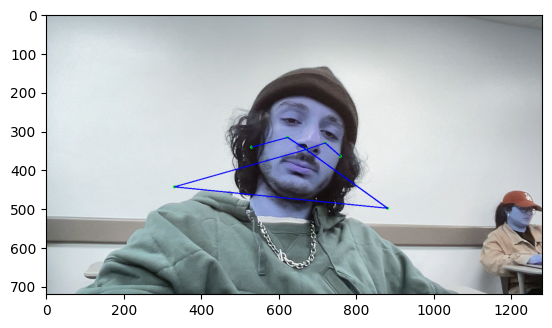

In [8]:
# Record information from last frame before closing
img = frame.copy()
resolution_Y = img.shape[0]
resolution_X = img.shape[1]
np.expand_dims(img,axis=0).shape

# Show last frame now
plt.imshow(frame)

In [9]:
# Show coordinates of nose in last frame
body_part = keypoints_with_scores[0][0][0]
np.array(body_part[:2]*[resolution_Y,resolution_X]).astype(int)

array([348, 671])

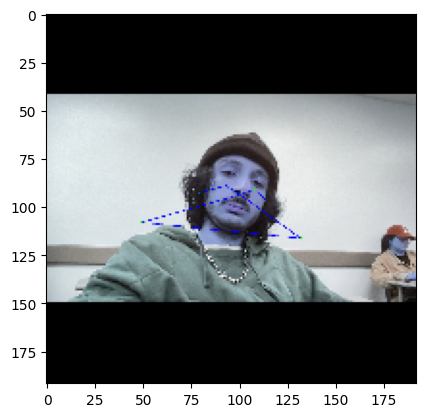

In [10]:
# Demonstration of image resizing with the last frame previously recorded
img_resize = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
img_resize = tf.cast(np.squeeze(img_resize), dtype=tf.int32)
plt.imshow(img_resize)